In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import flwr as fl
from flwr.common import Metrics
# DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
# print(
#     f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
# )

In [123]:
df = pd.read_csv('./data.csv')
normalize = ['temperature', 'pressure', 'humidity']
scaler = Normalizer()
df[normalize] = scaler.fit_transform(df[normalize])
df.head()

,temperature,pressure,humidity,type
0,0.321077,0.023410,0.946764,0
1,0.434641,0.013288,0.900506,0
2,0.433907,0.203278,0.877726,0
3,0.930075,0.027814,0.366315,0
4,0.956026,0.007590,0.293182,0


In [124]:
X = df.drop('type', axis=1).values
y = df['type'].values

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [126]:
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f'Using {device} device.')

# the choice of the number of hidden layers and the dimensionality of each layer may require experimentation and fine-tuning to achieve the best results for your specific dataset and problem. You can use techniques like cross-validation and grid search to optimize these hyperparameters.

class NeuralNetwork(nn.Module):
    def __init__(self, in_features=3, hidden_layer=128, out_features=8):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features, hidden_layer), 
            nn.ReLU(),
            nn.Linear(hidden_layer, hidden_layer), 
            nn.ReLU(),
            nn.Linear(hidden_layer, out_features), 
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

Using cpu device.
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=8, bias=True)
    (5): Softmax(dim=1)
  )
)


In [127]:
def saveModel(): 
    path = "./NetModel.pth" 
    torch.save(model.state_dict(), path)

In [128]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
train_losses = np.zeros(num_epochs)
test_losses  = np.zeros(num_epochs)

def train_network(model, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs, train_losses, test_losses):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output_train = model(X_train)
        loss_train = criterion(output_train, y_train)
        loss_train.backward()
        optimizer.step()

        output_test = model(X_test)
        loss_test = criterion(output_test,y_test)
        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()

        print(f"epoch {epoch+1}/{num_epochs}, train loss: {loss_train.item():.4f}, test loss: {loss_test.item():.4f}")
            
train_network(model, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs, train_losses, test_losses)

epoch 1/100, train loss: 2.0808, test loss: 2.0695
epoch 2/100, train loss: 2.0695, test loss: 2.0578
epoch 3/100, train loss: 2.0577, test loss: 2.0451
epoch 4/100, train loss: 2.0450, test loss: 2.0314
epoch 5/100, train loss: 2.0312, test loss: 2.0165
epoch 6/100, train loss: 2.0163, test loss: 2.0007
epoch 7/100, train loss: 2.0004, test loss: 1.9834
epoch 8/100, train loss: 1.9831, test loss: 1.9645
epoch 9/100, train loss: 1.9641, test loss: 1.9437
epoch 10/100, train loss: 1.9433, test loss: 1.9209
epoch 11/100, train loss: 1.9205, test loss: 1.8961
epoch 12/100, train loss: 1.8955, test loss: 1.8691
epoch 13/100, train loss: 1.8685, test loss: 1.8398
epoch 14/100, train loss: 1.8390, test loss: 1.8082
epoch 15/100, train loss: 1.8074, test loss: 1.7746
epoch 16/100, train loss: 1.7737, test loss: 1.7396
epoch 17/100, train loss: 1.7385, test loss: 1.7039
epoch 18/100, train loss: 1.7028, test loss: 1.6682
epoch 19/100, train loss: 1.6670, test loss: 1.6333
epoch 20/100, train l

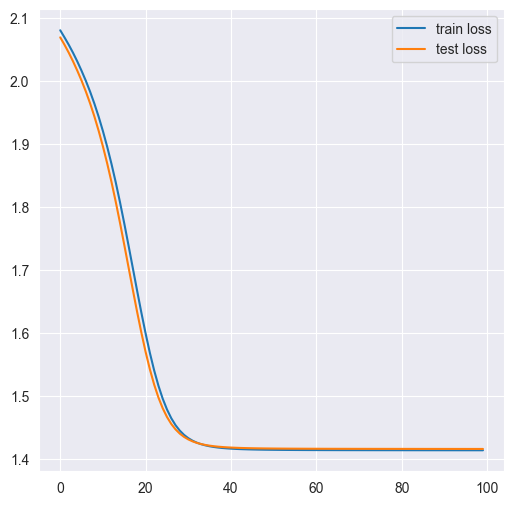

In [129]:
plt.figure(figsize=(6,6))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [130]:
predictions_train = []
predictions_test =  []
with torch.no_grad():
    predictions_train = model(X_train)
    predictions_test = model(X_test)

def get_accuracy_multiclass(pred_arr,original_arr):
    if len(pred_arr)!=len(original_arr):
        return False
    pred_arr = pred_arr.numpy()
    original_arr = original_arr.numpy()
    final_pred= []

    for i in range(len(pred_arr)):
        final_pred.append(np.argmax(pred_arr[i]))
    final_pred = np.array(final_pred)
    count = 0

    for i in range(len(original_arr)):
        if final_pred[i] == original_arr[i]:
            count+=1
    return count/len(final_pred)

train_acc = get_accuracy_multiclass(predictions_train,y_train)
test_acc  = get_accuracy_multiclass(predictions_test,y_test)

print(f"Training Accuracy: {round(train_acc*100,3)}")
print(f"Test Accuracy: {round(test_acc*100,3)}")

Training Accuracy: 86.121
Test Accuracy: 85.909
